# T2 map calculation tutorial

Start by importing the required libraries and defining some settings:

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from ukat.data import fetch
from ukat.mapping.t2 import T2

# Ensure figures are rendered in the notebook
%matplotlib inline

Tell python where to store the $T_2$ maps NIfTI files we will generate. We will store it in a directory called 
`t2_calculation_output` in the `tutorials` directory.

In [2]:
# Initialise output path for T2 map
directory = 't2_calculation_output'
os.makedirs(directory, exist_ok=True)
OUTPUT_DIR = os.path.join(os.getcwd(), directory)

Retrieve $T_2$ test data using our data fetcher.
This will return 3 variables:
* `image`: a 4D array with the magnitude data at all echo times.
* `affine`: the affine matrix for the data (needed to later write a new NIfTI file).
* `te`: an array containing the echo times, in seconds.

In [3]:
# Fetch test data
image, affine, te = fetch.t2_philips(1)
te = te * 1000  # convert TE to ms

Compute the $T_2$ maps using the `T2` class implemented in `mapping`.

Multiple models are available to fit data to. `2p_exp` fits the data to equation $S = S_0 \cdot e^{\frac{-t}{T2}}$ and 
`3p_exp` fits the data to equation $S = S_0 \cdot e^{\frac{-t}{T2}}+b$ where $b$ is a baseline noise term comprising of 
noise and very long $T_2$ components. Additionally a noise threshold can be specified to ommit late echos when the signal 
has recovered to the noise floor from the fitting process.

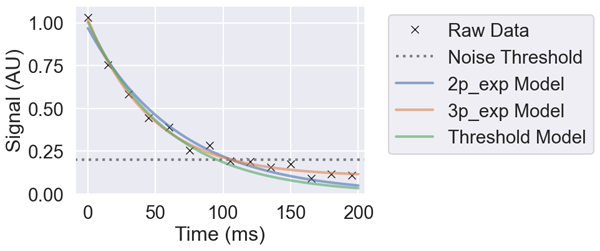

In this tutorial we are going to use the default `2p_exp` model.

In [4]:
# Initialise the mapping object
mapper = T2(image, te, affine=affine)

# Extract the T2 map from the object
t2_map = mapper.t2_map

# Save output maps to Nifti
mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='Philips2', maps='all')

100%|███████████████████████████████████████████████████████████████████████████████| 46080/46080 [05:35<00:00, 137.19it/s]
c:\users\md1jgra\desktop\ukat\ukat\mapping\t2.py:181: RuntimeWarning: divide by zero encountered in reciprocal
  return np.reciprocal(self.t2_map)


Display a central slice of the $T_2$ map and derived measures.

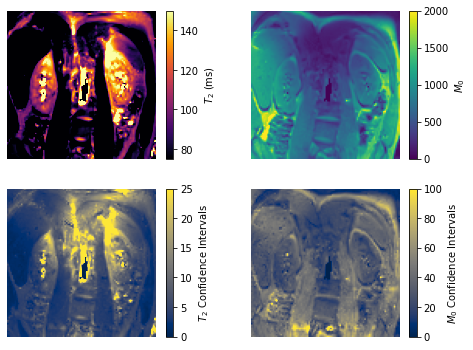

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# Display a central slice of the T2 map
im = ax[0, 0].imshow(np.rot90(t2_map[:, :, 2]), cmap='inferno', clim=(75, 150))
cb = fig.colorbar(im, ax=ax[0, 0])
cb.set_label('$T_2$ (ms)')
ax[0, 0].axis('off')

# Display a central slice of the M0 map
im = ax[0, 1].imshow(np.rot90(mapper.m0_map[:, :, 2]), cmap='viridis', clim=(0, 2000))
cb = fig.colorbar(im, ax=ax[0, 1])
cb.set_label('$M_0$')
ax[0, 1].axis('off')

# Display a central slice of the T2 confidence intervals
im = ax[1, 0].imshow(np.rot90(mapper.t2_err[:, :, 2]), cmap='cividis', clim=(0, 25))
cb = fig.colorbar(im, ax=ax[1, 0])
cb.set_label('$T_2$ Confidence Intervals')
ax[1, 0].axis('off')

# Display a central slice of the M0 confidence intervals
im = ax[1, 1].imshow(np.rot90(mapper.m0_err[:, :, 2]), cmap='cividis', clim=(0, 100))
cb = fig.colorbar(im, ax=ax[1, 1])
cb.set_label('$M_0$ Confidence Intervals')
ax[1, 1].axis('off')

plt.show()